# Perpetual swaps arbitrage

Definition of contract: https://www.deribit.com/pages/docs/perpetual. Importantly, given the mark price (essentially, current trading price) and the index price (essentially, price of underlying), the funding rate is equal to:

$$
\begin{align}
    r_p &= (\text{mark price} - \text{index price}) \: / \: \text{index price} \\
    r_f &= \max(0.05\%, \: r_p) - \min(-0.05\%, \: r_p)
\end{align}
$$

And the longs pay the shorts $r_f \times \text{ position size}$ at a regular interval. On Deribit, the funding is computed _every milisecond_ but settled every 8 hours. On Binance, the funding is computed and settled every 8 hours. If the funding rate is negative, the shorts pay the longs, but this is empirically rare. The arbitrage is then, using the underlying and cash settled perpetuals:

| Long underlying | Short perpetual |
| -------------- | -------------- |
| $- S_0$ ||
|| $+ r_{f1} * S_1$ |
|| $+ r_{f2} * S_2$ |
|| ... |
| $+ S_T$ | $+S_0 - S_T$ |

Below we compute the profit of applying this strategy to Ethereum perpetuals on the Deribit exchange. The Deribit exchange offers very low funding rates and therefore is unlikely to be the best exchange on which to apply this strategy.

In [8]:
import websockets
import asyncio as aio
import json
from datetime import datetime

In [11]:
url = 'wss://www.deribit.com/ws/api/v2'


async def api(msg):
    async with websockets.connect(url) as ws:
        await ws.send(json.dumps(msg))
        return json.loads(await ws.recv())

async def fr(fm, to):
    msg = {
        "jsonrpc": "2.0",
        "method": "public/get_funding_rate_history",
        "id": 7617,
        "params": {
            "instrument_name": "BTC-PERPETUAL",
            "start_timestamp": fm,
            "end_timestamp": to,
        }
    }

    return await api(msg)

def ts(dt):
    return int(1000 * dt.timestamp())

In [15]:
fm = datetime(2021, 4, 19)
to = datetime(2021, 4, 20)

rates = await fr(ts(fm), ts(to))
rates

{'jsonrpc': '2.0',
 'id': 7617,
 'result': [{'timestamp': 1618786800000,
   'prev_index_price': 56386.02,
   'interest_8h': 6.609820660874359e-07,
   'interest_1h': 7.454314948370582e-07,
   'index_price': 56664.59},
  {'timestamp': 1618790400000,
   'prev_index_price': 56664.59,
   'interest_8h': 5.94671748448578e-07,
   'interest_1h': 0.0,
   'index_price': 56266.31},
  {'timestamp': 1618794000000,
   'prev_index_price': 56266.31,
   'interest_8h': 1.3808492062907436e-07,
   'interest_1h': 0.0,
   'index_price': 56871.59},
  {'timestamp': 1618797600000,
   'prev_index_price': 56871.59,
   'interest_8h': -1.4917774192780839e-06,
   'interest_1h': -1.6776340055097267e-06,
   'index_price': 56878.89},
  {'timestamp': 1618801200000,
   'prev_index_price': 56878.89,
   'interest_8h': -4.125932117740075e-06,
   'interest_1h': -2.678285318409125e-06,
   'index_price': 57004.32},
  {'timestamp': 1618804800000,
   'prev_index_price': 57004.32,
   'interest_8h': -4.8364354339038994e-06,
   'in

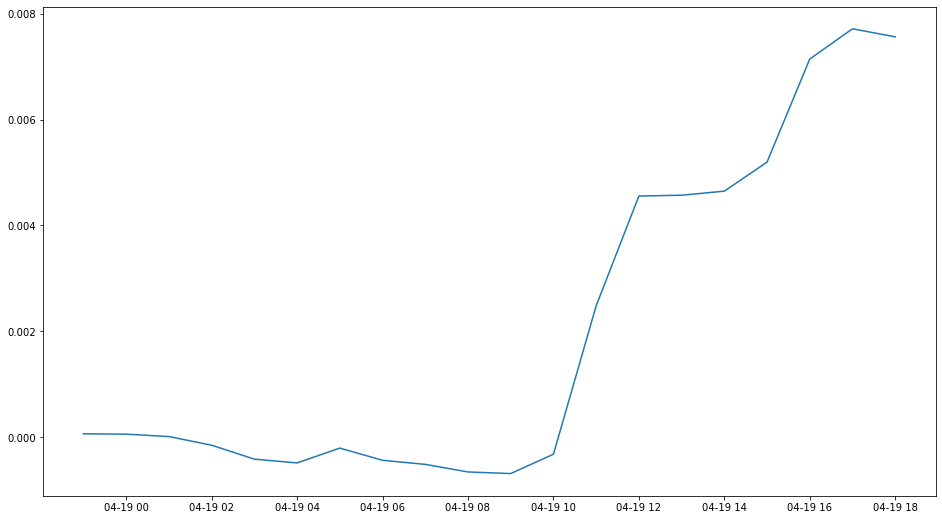

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


plt.figure(figsize=(16, 9))
df = pd.DataFrame.from_records(rates['result'])
plt.plot(pd.to_datetime(df['timestamp'], unit='ms'), df['interest_8h'] * 100)

In [14]:
dts = pd.to_datetime(df['timestamp'], unit='ms')
rts = df['interest_1h']

start = 100
for rt in rts.iloc:
    start += rt * start

start

103.77659174672104